In [1]:
import torch
print(torch.__version__)

1.11.0+cu113


In [2]:
#install required packages
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 33.0 MB/s 
     |████████████████████████████████| 3.5 MB 33.8 MB/s 


# make a visualization function
This function visualizes graph data into lower dimension for visualization purposes. It uses Sklearn TSNE module for plotting from higher dimensions to a lower dimension.

In [3]:
# helper function for visualization
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
  z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

  plt.figure(figsize = (10, 10))
  plt.xticks([])
  plt.yticks([])

  plt.scatter(z[:, 0], z[:, 1], s = 70, c = color, cmap = 'Set2')
  plt.show()

# Node classification with Graph Neural Networks
To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

Let's explore some info about the dataset, mainly the graph and links

In [4]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root = "data/Planetoid", name = "Cora", transform = NormalizeFeatures())
print(dataset)

print("---"*36)
print(f'length of the dataset: {len(dataset)}')
print(f'features in the dataset: {dataset.num_features}')
print(f'Number of classes in the dataset: {dataset.num_classes}')
print("---"*36)
data = dataset[0]
print('print dataset properties')
print(data)

print(f'Number of nodes in the dataset: {data.num_nodes}')
print(f'Number of edges in the dataset: {data.num_edges}')
print(f'Average Node degree: {data.num_edges/data.num_nodes:0.2f}')
print(f'number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {data.train_mask.sum()/data.num_nodes:0.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Cora()
------------------------------------------------------------------------------------------------------------
length of the dataset: 1
features in the dataset: 1433
Number of classes in the dataset: 7
------------------------------------------------------------------------------------------------------------
print dataset properties
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes in the dataset: 2708
Number of edges in the dataset: 10556
Average Node degree: 3.90
number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Processing...
Done!


In [5]:
from torch_geometric.nn import GCNConv 
import torch
import torch.nn.functional as F
class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(1234567)
    self.conv1 = GCNConv(dataset.num_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, dataset.num_classes)


  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p = 0.5, training = self.training)
    x = self.conv2(x, edge_index)
    return x
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


#plot the raw dataset


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


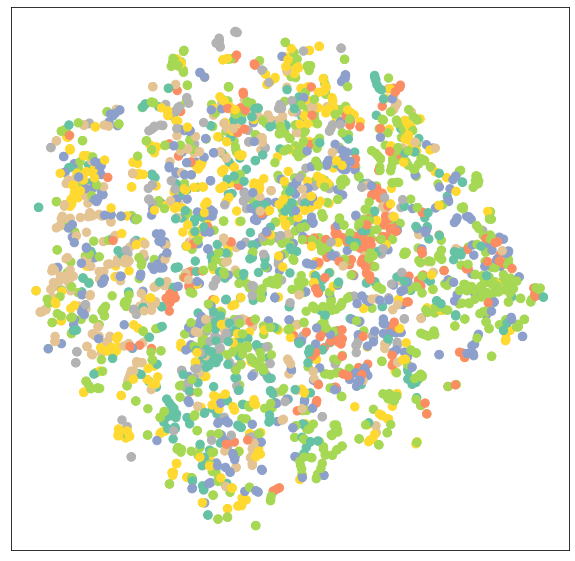

In [6]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color = data.y)

In [7]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


model = GCN(hidden_channels = 16)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss


def test():
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)
  corrects = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(corrects.sum())/int(data.test_mask.sum())
  return test_acc

for epoch in range(1, 101):
    loss = train()
    if epoch %10 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 010, Loss: 1.8685
Epoch: 020, Loss: 1.7310
Epoch: 030, Loss: 1.5576
Epoch: 040, Loss: 1.3258
Epoch: 050, Loss: 1.1296
Epoch: 060, Loss: 0.9741
Epoch: 070, Loss: 0.7711
Epoch: 080, Loss: 0.6755
Epoch: 090, Loss: 0.6535
Epoch: 100, Loss: 0.5799


#evaluation on the test set

In [8]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


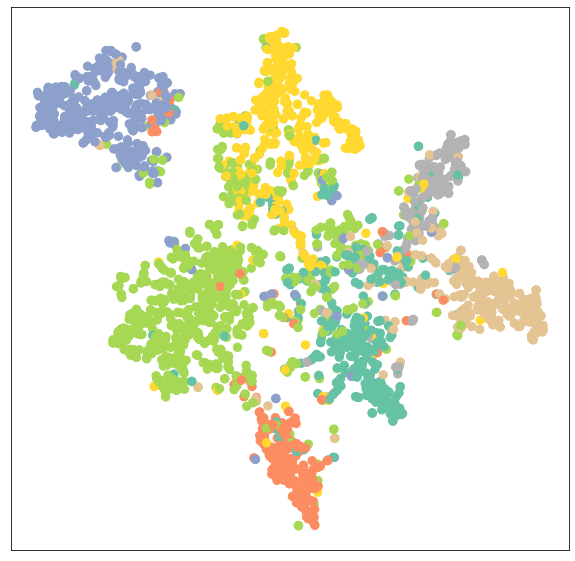

In [9]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)